In [1]:
import pygal
from IPython.display import SVG, display
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import folium
import mysql.connector
from sqlalchemy import create_engine

In [6]:
db_url = "mysql+mysqlconnector://{USER}:{PWD}@{HOST}/{DBNAME}"

db_url = db_url.format(
    USER = "root", 
    PWD = "QsLdzoV7u9ZxuIeL",
    HOST = "localhost:3306",
    DBNAME = "eventfrogdata"
)

In [10]:
engine = create_engine(db_url, echo=False)

with engine.begin() as conn:
    
    df = pd.read_sql_table(
        table_name='events_prepared',
        con=conn
    )
df.head()

,web-scraper-order,name,description,price,address,category,date_formatted,time_from,time_until,duration_seconds,...,description_len,lat,lon,bfs_nummer,gemeinde,distance_bahnhof,kanton,absolute_young_pop,relative_young_pop,pop_dens
0,1701178304-1235,Live-Musik mit Sina Anastasia,ihr name *ein hauch von melodie* ihre ausstra...,NaN,"Baselstrasse 43, Riehen",Konzert / Singer & Songwriter,2023/12/01,19:00:00,22:00:00,10800.0,...,2860.0,47.584694,7.649675,2703,Riehen,231.871315,BS,3679.0,16.8,1922.3
1,1701178306-1236,"Metal Marmot, 1. - 2. Dezember 2023",metal marmot im dezember 2023: freitag 1. deze...,40.0,"Kanderstegstrasse 25, Frutigen",Konzert / Hard Rock & Heavy Metal,2023/12/01,19:00:00,None,NaN,...,245.0,46.586052,7.647597,563,Frutigen,431.905393,BE,1621.0,23.1,95.4
2,1701178308-1237,JAMfreeday,alle sind herzlich eingeladen um zu musizieren...,NaN,"28, Herisau",Konzert,2023/12/01,19:00:00,None,NaN,...,188.0,47.387520,9.309265,3001,Herisau,1931.580777,AR,4094.0,26.0,624.2
3,1701178310-1238,Am Hummelwald,"der kurzprosaband ""am hummelwald - miniaturen ...",NaN,"St.Leonhard-Strasse 40, St.Gallen",Konzert,2023/12/01,19:00:00,None,NaN,...,1060.0,47.422333,9.370071,3203,St. Gallen,94.997717,SG,25343.0,32.9,1916.7
4,1701178312-1239,BELPHEGOR 30 Year Tour Special Guest: Arkona &...,belphegor marschiert durch europa winter mmxxi...,38.0,"Aarburg, CH",Konzert / Hard Rock & Heavy Metal,2023/12/01,19:00:00,23:50:00,17400.0,...,734.0,47.324833,7.905110,4271,Aarburg,559.350472,AG,2691.0,30.8,1781.0


# Non-graphical EDA

## Shape all events (number of rows and columns)

In [11]:
df.shape

(1543, 21)

## Shape of data that has no missing value (so it has a price and duration)

In [12]:
df_price = df.dropna()
df_price.shape

(374, 21)

## Summary statistics of numeric variables

In [13]:
df_price.describe()

,price,duration_seconds,is_concert,description_len,lat,lon,bfs_nummer,distance_bahnhof,absolute_young_pop,relative_young_pop,pop_dens
count,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000,374.000000
mean,24.544652,17832.513369,0.529412,1435.117647,47.292046,8.326886,1980.700535,730.037361,44922.248663,29.815775,2716.490107
std,14.889475,8152.534276,0.499803,1589.782323,0.240267,0.634285,1577.139616,742.207398,58710.869170,4.541379,2242.757484
min,0.000000,3600.000000,0.000000,18.000000,46.295605,6.647134,2.000000,25.709271,148.000000,16.800000,10.600000
25%,15.000000,10800.000000,0.000000,513.750000,47.143669,7.714313,261.000000,345.019350,2912.000000,26.600000,840.200000
50%,24.975000,18000.000000,1.000000,833.500000,47.375475,8.451987,1953.500000,531.288302,7409.500000,30.400000,1781.000000
75%,30.000000,23400.000000,1.000000,1374.000000,47.444996,8.556387,3276.000000,862.605955,52836.000000,33.600000,4580.500000
max,130.000000,43200.000000,1.000000,13991.000000,47.697395,10.275710,6297.000000,6023.316921,150915.000000,36.300000,7170.500000


## Skewness

In [14]:
df_price[['price', 'duration_seconds', 'description_len', 'distance_bahnhof', 'relative_young_pop', 'pop_dens']].skew()

price                 2.223245
duration_seconds      0.170403
description_len       2.683530
distance_bahnhof      3.717600
relative_young_pop   -0.535015
pop_dens              0.699682
dtype: float64

## Kurtosis

In [15]:
df_price[['price', 'duration_seconds', 'description_len', 'distance_bahnhof', 'relative_young_pop', 'pop_dens']].kurtosis()

price                 10.809757
duration_seconds      -0.496729
description_len       12.466897
distance_bahnhof      19.660409
relative_young_pop    -0.418454
pop_dens              -0.710574
dtype: float64

## Cross-tabulation
Shows the relation between if an event is a concert or party and it's price

In [16]:
pd.crosstab(df_price['is_concert'], df['price'])

price,0.0,5.0,8.0,9.0,10.0,12.0,12.9,13.0,15.0,16.0,...,50.0,53.0,58.0,59.0,60.0,68.0,85.0,99.0,110.0,130.0
is_concert,,,,,,,,,,,,,,,,,,,,,
0,0,7,7,1,31,3,2,1,26,1,...,0,0,0,4,0,1,0,1,0,1
1,11,0,1,0,4,0,0,4,14,0,...,6,1,1,1,1,0,1,0,1,0


## Correlation matrix

In [17]:
corr = df_price[['price', 
          'duration_seconds', 
          'description_len', 
          'distance_bahnhof',
          'relative_young_pop',
          'pop_dens']].cov().corr()
corr

,price,duration_seconds,description_len,distance_bahnhof,relative_young_pop,pop_dens
price,1.000000,-0.924486,0.352042,-0.057109,-0.474793,-0.406547
duration_seconds,-0.924486,1.000000,-0.076907,0.107167,0.273257,0.155626
description_len,0.352042,-0.076907,1.000000,-0.307569,0.035870,-0.052828
distance_bahnhof,-0.057109,0.107167,-0.307569,1.000000,-0.643079,-0.553863
relative_young_pop,-0.474793,0.273257,0.035870,-0.643079,1.000000,0.979789
pop_dens,-0.406547,0.155626,-0.052828,-0.553863,0.979789,1.000000


# Graphical EDA

## Boxplot for the price

<AxesSubplot:xlabel='price'>

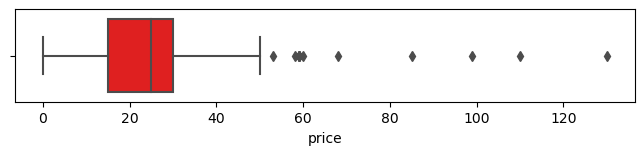

In [18]:
plt.figure(figsize=(8,1.2))
plt.ticklabel_format(style='plain')
sns.boxplot(x=df_price['price'], color="red")

## Remove outliers

In [19]:
df_price = df_price.loc[df_price['price'] < 100]
df_price.shape

(372, 21)

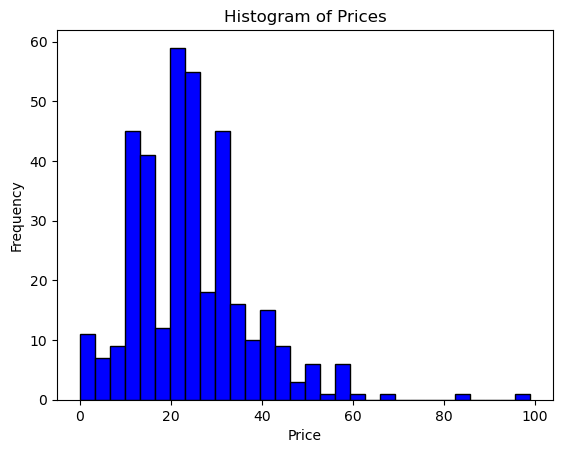

In [20]:
plt.hist(df_price['price'], bins=30, color='blue', edgecolor='black')

plt.title('Histogram of Prices')
plt.xlabel('Price')
plt.ylabel('Frequency')

plt.show()

## Scatterplot

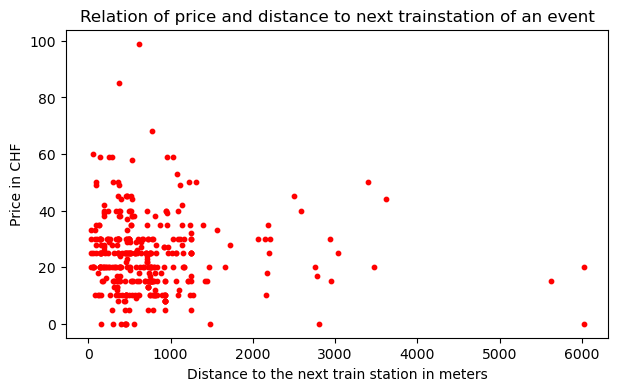

In [21]:
plt.figure(figsize=(7,4))
plt.scatter(df_price['distance_bahnhof'], 
           df_price['price'], 
           color="red", 
           alpha=1.0,
           s=10)
plt.title('Relation of price and distance to next trainstation of an event', fontsize=12)
plt.xlabel('Distance to the next train station in meters')
plt.ylabel('Price in CHF')
plt.show()

# Visualization of geographical data

## Map of all events

In [22]:
# Initialisierung der Map
m = folium.Map(location=[46.8, 8.1], zoom_start=8)

for i in range(0, len(df_price)):
    folium.Marker(location=(df.iloc[i]['lat'], 
                            df.iloc[i]['lon']), 
                  popup=df.iloc[i]['address']).add_to(m)

# Layer control
folium.LayerControl().add_to(m)

# Plot map
m

## Distribution of events by cantons

In [23]:
kanton_count = df["kanton"].value_counts().to_dict()
kanton_count_map = {}
for k, v in kanton_count.items():
    kanton_count_map["kt-" + k.lower()] = v # The switzerland map needs the cantons in the format 'kt-..' for example 'kt-zh'

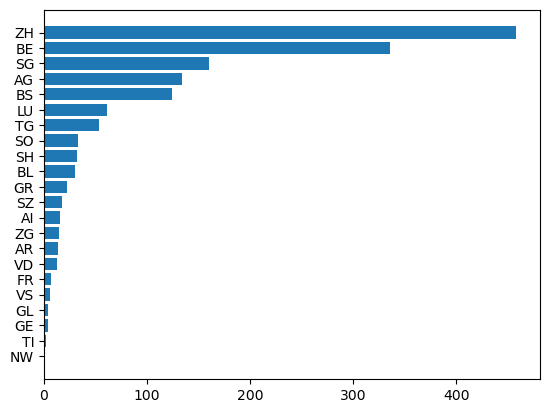

In [24]:
df_count = pd.DataFrame.from_dict(kanton_count, orient="index")
df_count.reset_index(inplace=True)
df_count = df_count.rename(columns = {'index':'kanton', 0: 'count'})
df_count = df_count.sort_values('count', ascending=True)

plt.barh(df_count['kanton'], df_count['count'])
plt.show()

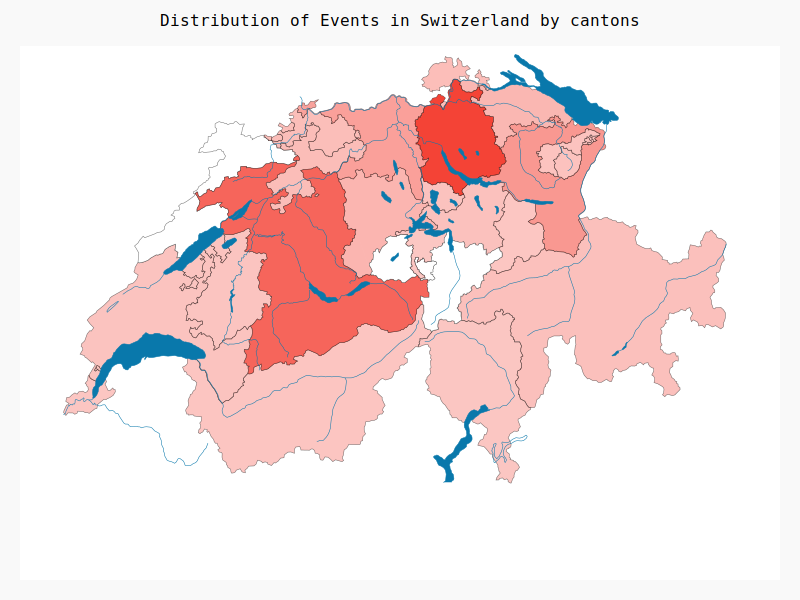

In [25]:
ch_chart = pygal.maps.ch.Cantons(show_legend=False)
ch_chart.title = 'Distribution of Events in Switzerland by cantons'

ch_chart.add('Random Data', kanton_count_map) 


display(SVG(ch_chart.render(disable_xml_declaration=True)))

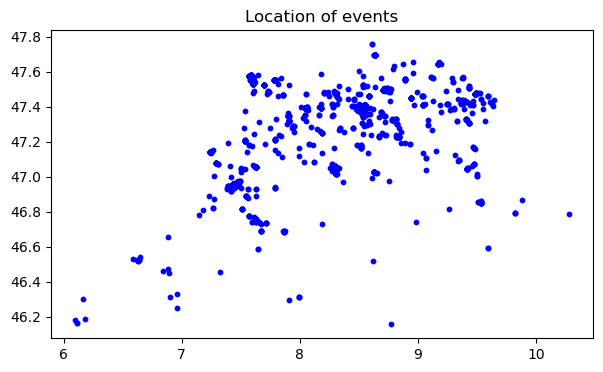

In [26]:
plt.figure(figsize=(7,4))
plt.scatter(df['lon'], 
           df['lat'], 
           color="Blue", 
           alpha=1.0,
           s=10)
plt.title('Location of events', fontsize=12)
plt.show()

## Distribution concert/party

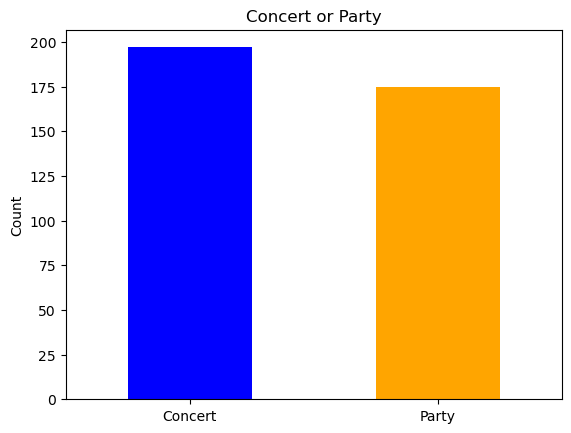

In [27]:
concert_counts = df_price['is_concert'].value_counts()

# Create a bar chart
concert_counts.plot(kind='bar', color=['blue', 'orange'])

plt.title('Concert or Party')
plt.ylabel('Count')
plt.xticks([0, 1], ['Concert', 'Party'], rotation=0)  # Set the x-ticks to be more descriptive

plt.show()

### Jupyter notebook --footer info--

In [94]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Darwin | 23.1.0
Datetime: 2023-12-02 23:28:40
Python Version: 3.9.13
-----------------------------------
